Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [6]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [7]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [8]:
dataset_name = 'Amazon_Books'
user_col = 'user_id'

In [9]:
# data = pd.read_csv('output/amazonbooks_dump/sampled_amazon_books.csv')

In [10]:
# importa dataset 'amazon books'
data = pd.read_csv("../datasets/Books.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])

In [11]:
data.shape

(51311621, 4)

In [12]:
data.head()

,user_id,item_id,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
1,0001713353,A1REUF3A1YCPHM,5.0,1112140800
2,0001713353,A1YRBRK2XM5D5,5.0,1081036800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
4,0001713353,A2ZB06582NXCIV,5.0,1475452800


In [13]:
# data['item_id'].nunique() # 15362619

15362619

### Keep only high ratings

<AxesSubplot:ylabel='Frequency'>

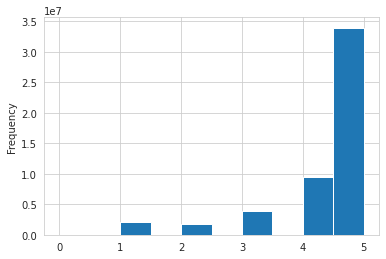

In [14]:
data['rating'].plot(kind='hist')

In [15]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [16]:
pos_ratings

5.0

In [17]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [18]:
# number of remaining cases
data.shape[0]

33979736

### Convert timestamp

In [19]:
%%time
# 56.6 s
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: user 56.6 s, sys: 3.44 s, total: 1min
Wall time: 60 s


In [20]:
data.head()

,user_id,item_id,timestamp,date
3476836,0140125183,A2P9YDRHZTJMC3,833500800,1996-05-31
18394619,0876851898,A3CX6N6BFFV1NS,835315200,1996-06-21
12923138,0553092626,A3RTKL9KB8KLID,840240000,1996-08-17
890264,0045300232,A3RTKL9KB8KLID,843004800,1996-09-18
17596157,0806128887,A1G2W2C669C8GC,848016000,1996-11-15


In [21]:
data.tail()

,user_id,item_id,timestamp,date
51304223,B01G9NVTSI,AHJDHJFLP7CPD,1538265600,2018-09-30
51304951,B01GEXSYXQ,A18RHTVSMBC6SP,1538352000,2018-10-01
51309931,B01HB9Q7CW,A2UUXH691JARF3,1538352000,2018-10-01
51309500,B01H7ZJRNG,AEC2WVP8H25HF,1538438400,2018-10-02
51307743,B01GW712JW,A2ZXRFUDBCF5KR,1538438400,2018-10-02


In [22]:
%%time
# 6 min 15s
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: user 6min 24s, sys: 4.96 s, total: 6min 29s
Wall time: 6min 29s


## Evaluating Time defined Buckets 

Sampling the dataset

In [23]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 25.9 s, sys: 753 ms, total: 26.6 s
Wall time: 26.5 s


<AxesSubplot:xlabel='date'>

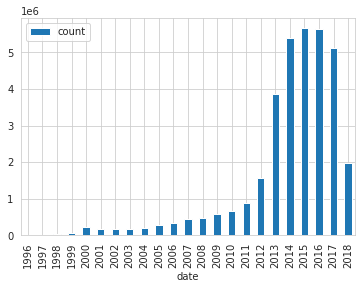

In [24]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar')

In [25]:
# y_filter = (data['date'] < datetime.strptime('2018', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 
y_filter = (data['date'] < datetime.strptime('2015-01', '%Y-%m')) & (datetime.strptime('2014-01', '%Y-%m') <= data['date']) 

In [26]:
y_filter.sum()

5401730

In [27]:
data = data[y_filter.tolist()]

In [28]:
# number of remaining cases
data.shape[0]

5401730

**Sampling the dataset - only most frequent users**

In [29]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 6.79 s, sys: 232 ms, total: 7.02 s
Wall time: 7.06 s


<AxesSubplot:ylabel='Frequency'>

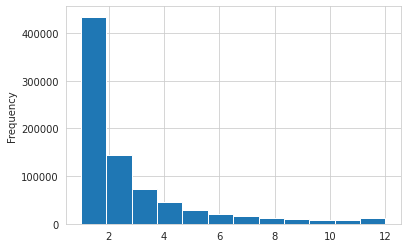

In [30]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [44]:
# we'll filter users with frequency higher than q - only users that occur in every month for q = 1
threshold = np.quantile(user_freq_over_months, q=1)
threshold

12

In [45]:
# there are this many users with freq above the threshold
(user_freq_over_months >= threshold).sum()

13009

In [46]:
# index of frequent users
freq_users = user_freq_over_months[user_freq_over_months >= threshold].index

In [50]:
# sample the dataset to contain only interactions from frequent users (that occur every month).
# there is still a huge number of interactions - 1694351
_ = data.set_index('user_id').loc[freq_users]
_.shape

(1694351, 3)

<AxesSubplot:>

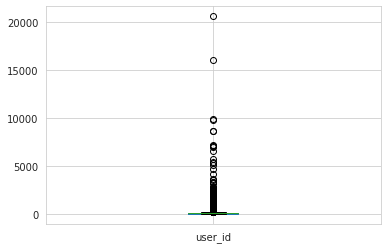

In [70]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box')

In [125]:
# sample again:
# the frequency of the 500th user with most interactions is used as threshold
threshold = _.reset_index()['user_id'].value_counts().iloc[:500].min()
freq_users = _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ].index

In [127]:
_.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ]

0141353678    20636
0007420412    16105
0439023521     9875
8184776217     9862
0099911701     8711
              ...  
1491231130      442
0307476413      442
0739380338      442
0399146237      441
0140390316      441
Name: user_id, Length: 500, dtype: int64

In [129]:
# 564099 cases remain - lets see if its enough
_.loc[freq_users].reset_index()

,user_id,item_id,timestamp,date
0,0141353678,A2YYLQVZSEPYH7,1388534400,2014-01-01
1,0141353678,AFW1UAPQ48L83,1388534400,2014-01-01
2,0141353678,A3P4DMNLO7KP9L,1388534400,2014-01-01
3,0141353678,AZZ8RTLB2RUF8,1388534400,2014-01-01
4,0141353678,A38XWJWI2W9QRS,1388534400,2014-01-01
...,...,...,...,...
564094,0140390316,AHG9X5ANO2GXD,1419811200,2014-12-01
564095,0140390316,A2S41GHZZX808E,1419897600,2014-12-01
564096,0140390316,AKOENOAP5UYU2,1419897600,2014-12-01
564097,0140390316,A3OBNS2TA5PRTP,1419984000,2014-12-01


In [132]:
# previous (huge) sample
# data = data.set_index('user_id').loc[freq_users].reset_index()
# new sample - only 500 most frequent users, from users that occur in every month
data = _.loc[freq_users].reset_index()

In [133]:
# number of remaining cases
data.shape[0]

564099

In [154]:
# sort by timestamp
data = data.sort_values(by=['timestamp'])

In [155]:
# previous (huge) sample
# data.to_csv('output/amazonbooks_dump/sampled_amazon_books.csv', index=False)

# new sample
data.to_csv('output/amazonbooks_dump/2nd_sampled_amazon_books.csv', index=False)

How many interactions occur in each month / year?

CPU times: user 419 ms, sys: 27.5 ms, total: 447 ms
Wall time: 498 ms


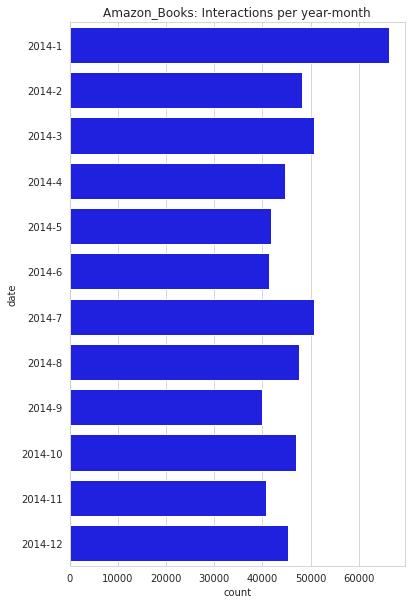

In [156]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [169]:
%%time
# 1.66s new sample time
# 1h 11s previous sample time
# user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions = get_interactions_info(data=data, user_col=user_col, quarter_info=True)

# previous huge sample
# user_presence_df.to_csv('output/amazonbooks_dump/user_presence_df.csv', index=False)
# user_month_interactions.to_csv('output/amazonbooks_dump/user_month_interactions.csv', index=False)

# new sample
user_presence_df.to_csv('output/amazonbooks_dump/2nd_sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazonbooks_dump/2nd_sample_user_month_interactions.csv', index=False)

# joblib.dump(trimestres, 'output/amazonbooks_dump/2nd_sample_trimestres.joblib' )
# user_trimestre_interactions.to_csv('output/amazonbooks_dump/2nd_sample_user_trimestre_interactions.csv', index=False)

0.0 %
5.0 %
10.0 %
15.0 %
20.0 %
25.0 %
30.0 %
35.0 %
40.0 %
45.0 %
50.0 %
55.0 %
60.0 %
65.0 %
70.0 %
75.0 %
80.0 %
85.0 %
90.0 %
95.0 %
CPU times: user 1.53 s, sys: 11.5 ms, total: 1.54 s
Wall time: 1.66 s


In [158]:
# user_presence_df = pd.read_csv('output/amazonbooks_dump/user_presence_df.csv')
# user_month_interactions = pd.read_csv('output/amazonbooks_dump/user_month_interactions.csv')

In [171]:
user_presence_df.head()

,UserID,month_%,trimestre_%
0,0001048767,1.0,1.0
1,0140861750,1.0,1.0
2,0399146237,1.0,1.0
3,0002247399,1.0,1.0
4,1455521299,1.0,1.0


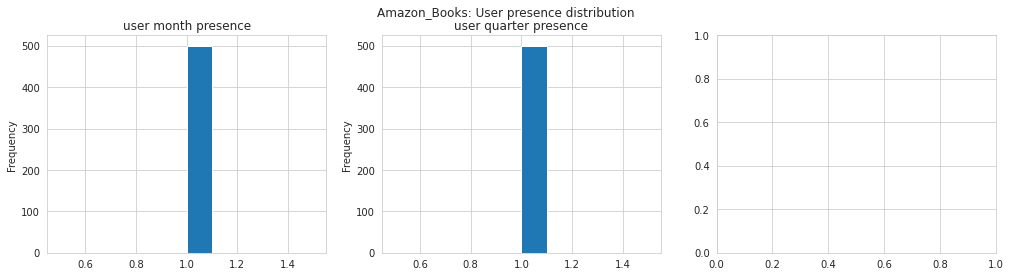

In [172]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

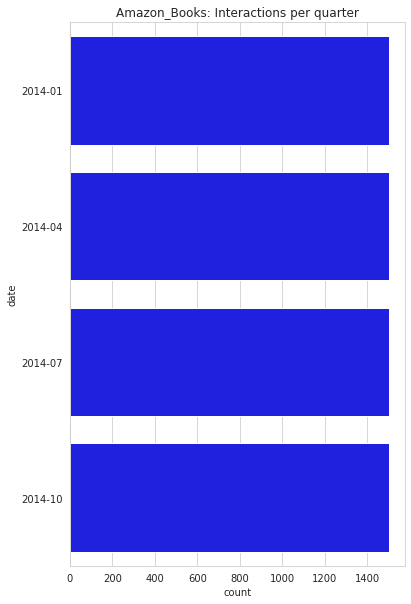

In [173]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [162]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [175]:
# defining threshold
frequency_threshold = 0.8

In [176]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

500 users of 500 (100.0%) occurr in 80.0% or more months.
500 users of 500 (100.0%) occurr in 80.0% or more quarters.


In [165]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/amazonbooks_dump/2nd_sample_frequent_users_month.joblib')

['output/amazonbooks_dump/2nd_sample_frequent_users_month.joblib']

In [1]:
a = {'a':[]}

In [2]:
a['b'] = []

In [4]:
a[f'bucket_{0}'] = []

In [6]:
del a['a']

In [7]:
a

{'b': [], 'bucket_0': []}

In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [ ]:
# freq_user_quarter_info = get_frequent_user_statistics(
#     interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# # freq_user_quarter_info

In [ ]:
# freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')

In [ ]:
# freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [ ]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [ ]:
# freq_user_semester_info = get_frequent_user_statistics(
#     interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# # freq_user_semester_info

In [ ]:
# freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')

In [ ]:
# freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [ ]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [ ]:
# # these are the users that should be used in holdouts, and only their last interactions
# # BUT, there are users that do not appear in some intervals, and some have only one interaction
# user_trimestre_interactions.loc[frequent_users_trimestre]
# user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [80]:
# n_iter_bucket = 50E3

# interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

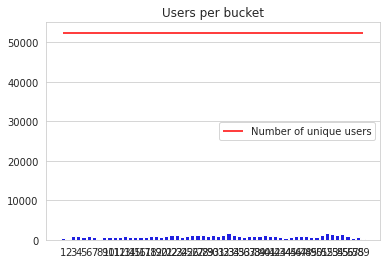

In [81]:
# plot_users_per_fixed_bucket(data, user_col, interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [83]:
# %%time
# # 2h 52min 2s
# user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end)

CPU times: user 2h 52min 1s, sys: 1.53 s, total: 2h 52min 2s
Wall time: 2h 52min 2s


In [84]:
# frequency_threshold = 0.8

In [85]:
# frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

0 users of 52474 (0.0%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [86]:
# freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)

<AxesSubplot:>

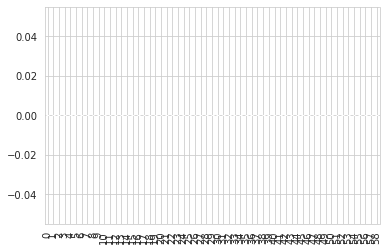

In [87]:
# freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

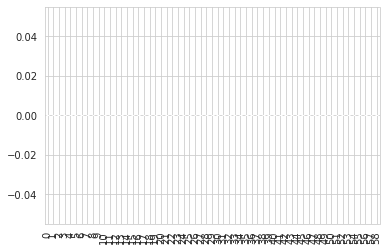

In [88]:
# freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

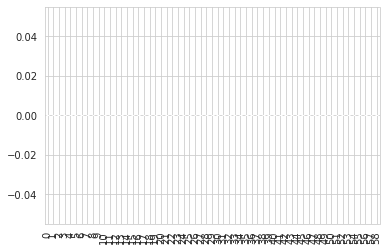

In [89]:
# frequent users interactions per bucket
# plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

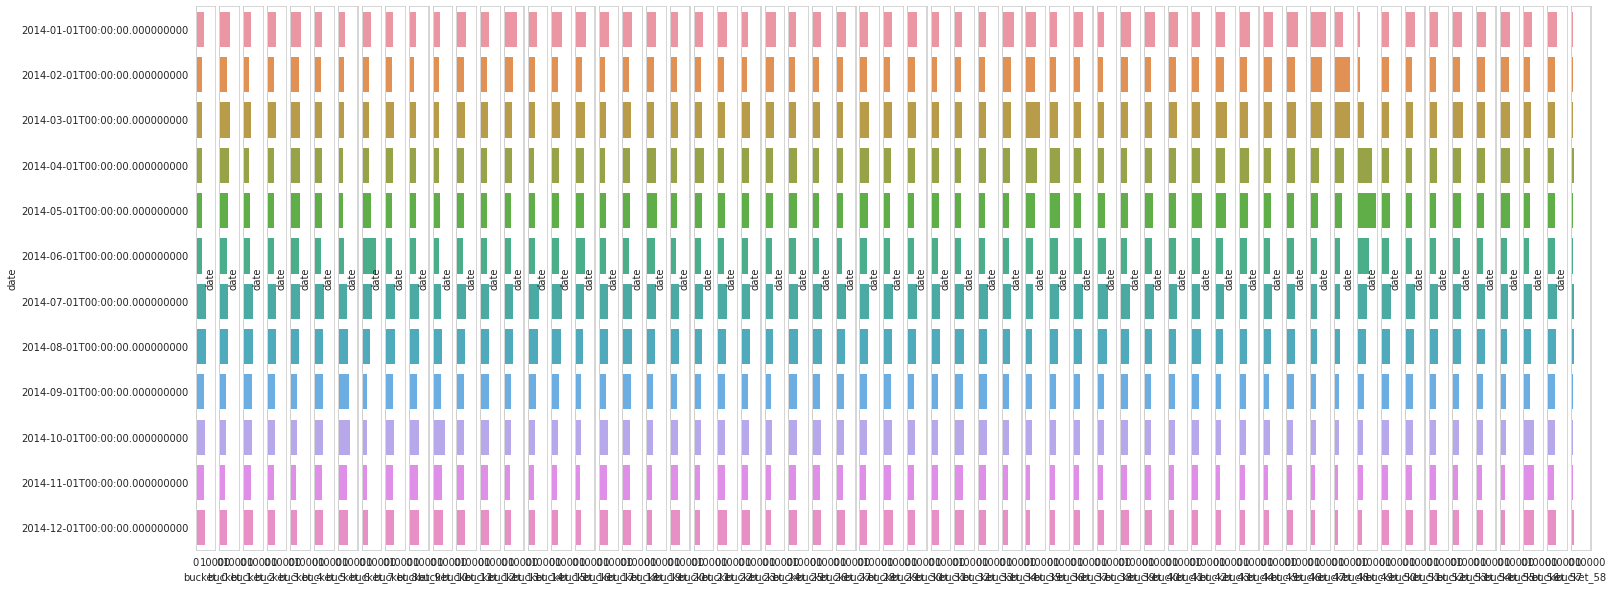

In [90]:
# plot_timestamps_per_bucket(dates_fixed_buckets_df)

___
## Store Buckets

In [ ]:
# # transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# # recebe listas
# stream = ImplicitData(data['user_id'], data['item_id'])

# empty_stream = ImplicitData([], [])

In [ ]:
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [ ]:
# # O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# # Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
# n_holdouts = int( data.shape[0]/n_iter_bucket )
# eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
# _=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
# joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)